In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
n_splits = 2
import sys
case=2
a=2
cost='abs'

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)

In [56]:
from common import compute_rmse
pred = {}
sd = {}
out = {}
for n_splits in range(2, len(df)):
    percentage = 100/n_splits
    print n_splits, percentage
    pred[percentage] = {}
    sd[percentage] = {}
    out[percentage] = {}
    kf = KFold(n_splits=n_splits)
    
    for test, train in kf.split(df):
#         assert(len(test)+1>=len(train))  
        
        train_ix = df.index[train]
        
        test_ix = df.index[test]

        tensor_copy = tensor.copy()
        tensor_copy[test, 1:, :] = np.NaN
        H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
        HAT = multiply_case(H, A, T, case)
        for appliance in APPLIANCES_ORDER:
            if appliance not in pred[percentage]:
                pred[percentage][appliance] = []

            pred[percentage][appliance].append(pd.DataFrame(HAT[test, appliance_index[appliance], :], index=test_ix))
#     print pred
    
    
    for appliance in APPLIANCES_ORDER:
        temp = pd.concat(pred[percentage][appliance])
        assert(len(temp)==len(df)*(n_splits-1))
        pred[percentage][appliance] = temp.groupby(temp.index).mean().ix[df.index]
        sd[percentage][appliance] = temp.groupby(temp.index).mean().ix[df.index]
    
   
    for appliance in APPLIANCES_ORDER[1:]:
        
        if appliance=="hvac":
            out[percentage][appliance] = compute_rmse(appliance, pred[percentage][appliance][range(4, 10)],'SanDiego')[2]
        else:   
            out[percentage][appliance] = compute_rmse(appliance, pred[percentage][appliance],'SanDiego')[2]
    
    if n_splits == 2:
        continue
    
    percentage = 100 - percentage
    print percentage
    pred[percentage] = {}
    sd[percentage] = {}
    out[percentage] = {}
    print out

    for train, test in kf.split(df):
        train_ix = df.index[train]
        test_ix = df.index[test]
        tensor_copy = tensor.copy()
        tensor_copy[test, 1:, :] = np.NaN
        H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
        HAT = multiply_case(H, A, T, case)
        for appliance in APPLIANCES_ORDER:
            if appliance not in pred[percentage]:
                pred[percentage][appliance] = []

            pred[percentage][appliance].append(pd.DataFrame(HAT[test, appliance_index[appliance], :], index=test_ix))
    
    for appliance in APPLIANCES_ORDER:
        temp = pd.concat(pred[percentage][appliance])
#         assert(len(temp)==len(df)*(n_splits-1))
        pred[percentage][appliance] = temp.groupby(temp.index).mean().ix[df.index]
        sd[percentage][appliance] = temp.groupby(temp.index).mean().ix[df.index]
    
   
    for appliance in APPLIANCES_ORDER[1:]:
        
        if appliance=="hvac":
            out[percentage][appliance] = compute_rmse(appliance, pred[percentage][appliance][range(4, 10)],'SanDiego')[2]
        else:   
            out[percentage][appliance] = compute_rmse(appliance, pred[percentage][appliance],'SanDiego')[2]

2 50
3 33
67
{33: {'hvac': 95.512542616588902, 'wm': 2.9296657944772369, 'fridge': 20.585540272090341, 'mw': 5.7407582158342603, 'oven': 6.886786136652379, 'dw': 6.1140203400257107}, 50: {'hvac': 93.136171430140635, 'wm': 3.7150880714173393, 'fridge': 19.627917385132491, 'mw': 6.0323145074702005, 'oven': 7.16836044572793, 'dw': 6.3950776081885623}, 67: {}}
4 25
75
{75: {}, 33: {'hvac': 95.512542616588902, 'wm': 2.9296657944772369, 'fridge': 20.585540272090341, 'mw': 5.7407582158342603, 'oven': 6.886786136652379, 'dw': 6.1140203400257107}, 50: {'hvac': 93.136171430140635, 'wm': 3.7150880714173393, 'fridge': 19.627917385132491, 'mw': 6.0323145074702005, 'oven': 7.16836044572793, 'dw': 6.3950776081885623}, 67: {'hvac': 103.72744597181027, 'wm': 3.0621454163682129, 'fridge': 21.448726650318925, 'mw': 5.948925511296836, 'oven': 6.9419417329528503, 'dw': 5.9939301777647023}, 25: {'hvac': 108.13981786993621, 'wm': 3.0395888038306129, 'fridge': 21.999524676937874, 'mw': 5.690517390448278, 'ove

In [7]:
from plot_functions import *

In [27]:
c.columns[::-1]

Float64Index([         50.0, 33.3333333333,          25.0,          20.0,
              16.6666666667, 14.2857142857,          12.5, 11.1111111111,
                       10.0, 9.09090909091, 8.33333333333, 7.69230769231,
              7.14285714286],
             dtype='float64')

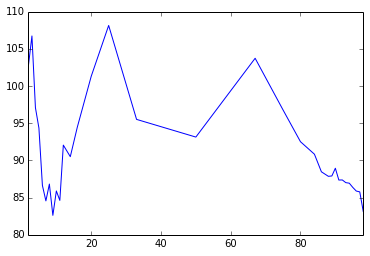

In [58]:
pd.DataFrame(out).ix['hvac'][:].plot()

In [62]:
c = pd.DataFrame(out)
# c.columns = [100.0/x for x in c.columns]
# c = c[c.columns[::-1]]

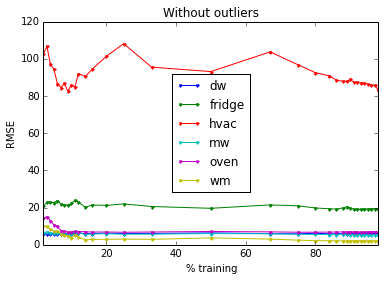

In [65]:
ax = c.T.plot(marker='.')
ax.set_xlabel("% training")
ax.set_ylabel("RMSE")
ax.set_title("Without outliers")

0 hvac
1 fridge
2 mw
3 dw
4 wm
5 oven


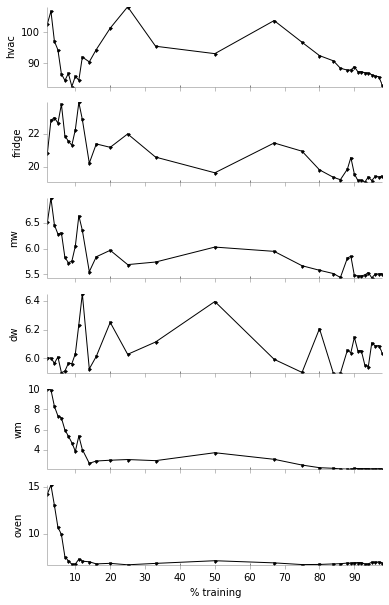

In [64]:
fig, ax = plt.subplots(nrows=6, figsize=(6, 10), sharex=True)
for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
    print i, appliance
    c.T[appliance].plot(ax=ax[i], color='k', marker='.',  logx=False)
    format_axes(ax[i])
    ax[i].set_ylabel(appliance)
    ax[i].locator_params(tight=True, nbins=4, axis='y')
ax[-1].set_xlabel("% training");
ax[-1].locator_params(tight=True, nbins=10, axis='x')

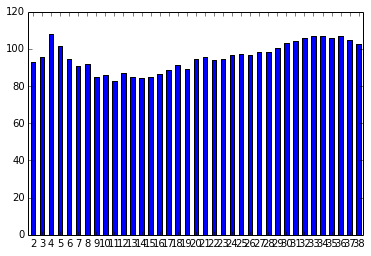

In [31]:
pd.DataFrame(out).ix['hvac'].plot(kind='bar',rot=0)


In [32]:
from common import compute_rmse_fraction, compute_rmse

In [33]:
appliance='hvac'
gtf, pf, rms, f = compute_rmse(appliance, pred[n_splits][appliance][range(4, 10)],'SanDiego')
f[f>np.percentile(f, 90)].sort_values()[::-1].head(10)

hvac_9  527     343.676079
hvac_8  1524    325.023546
hvac_9  1524    315.281314
hvac_8  527     307.109401
hvac_9  9370    270.597042
hvac_8  9370    263.785679
hvac_7  9370    256.619547
hvac_9  2606    247.074447
hvac_5  9370    239.251467
hvac_9  4095    232.697338
dtype: float64

In [34]:
def analysis(appliance, home, month):
    analysis_ser = pd.Series([gtf.ix['%s_%d' %(appliance, month),home],
                             pf.ix['%s_%d' %(appliance, month),home],
                             df.loc[home,'%s_%d' %("aggregate",month)]])
    analysis_ser.index = ['Appliance GT % of agg','Appliance Pred % of agg', 'GT (aggregate) [kWh]']
    return analysis_ser

In [35]:
analysis('hvac', 527, 8)

Appliance GT % of agg       577.740662
Appliance Pred % of agg     270.631260
GT (aggregate) [kWh]       1157.161133
dtype: float64

In [36]:
from plot_functions import *
def plot_appliances_aggregate(home, appliances=['hvac']):
    temp = {} 
    temp['aggregate'] = df.ix[home][['aggregate_%d' %month for month in range(1, 13)]].values
    for appliance in appliances:
        temp[appliance] = df.ix[home][['%s_%d' %(appliance, month) for month in range(1, 13)]].values
    temp_df = pd.DataFrame(temp, index=range(1, 13))
    temp_df.plot(color=tableau20blind[::2])
    format_axes(plt.gca())
    plt.xlabel("Month of year")
    plt.ylabel("Energy (kWh)")

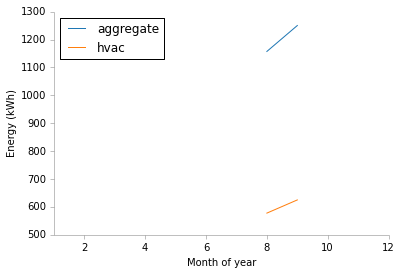

In [37]:
plot_appliances_aggregate(527)

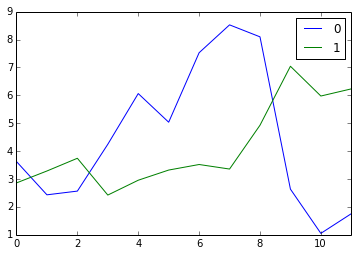

In [38]:
pd.DataFrame(T).plot()

In [39]:
pd.Series(out)

2     {u'hvac': 93.1361714301, u'wm': 3.71508807142,...
3     {u'hvac': 95.5125426166, u'wm': 2.92966579448,...
4     {u'hvac': 108.13981787, u'wm': 3.03958880383, ...
5     {u'hvac': 101.307209186, u'wm': 2.97143922342,...
6     {u'hvac': 94.449082902, u'wm': 2.89436931456, ...
7     {u'hvac': 90.5011179737, u'wm': 2.66408894617,...
8     {u'hvac': 92.056948, u'wm': 4.03260281686, u'f...
9     {u'hvac': 84.6216941206, u'wm': 5.36455143841,...
10    {u'hvac': 85.891927041, u'wm': 3.85769501997, ...
11    {u'hvac': 82.6136713464, u'wm': 4.70534850681,...
12    {u'hvac': 86.8208639193, u'wm': 5.35925088581,...
13    {u'hvac': 84.9162079474, u'wm': 6.34317019694,...
14    {u'hvac': 84.5594334456, u'wm': 5.98048654547,...
15    {u'hvac': 85.0504154033, u'wm': 6.66033268895,...
16    {u'hvac': 86.6409422115, u'wm': 7.15776199163,...
17    {u'hvac': 88.3894004223, u'wm': 7.46966745083,...
18    {u'hvac': 91.2092049495, u'wm': 7.72867852123,...
19    {u'hvac': 89.3004651898, u'wm': 7.56415007

In [40]:
pred['hvac'].describe()

KeyError: 'hvac'